# Neural Network für klassifizierung von arabischen Zahlen

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import gzip
import struct
import os

In [2]:
dataset_folder = os.path.abspath("./emnist_dataset")
print(dataset_folder)

/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/neural_network/emnist_dataset


Klasse für Model definieren:

In [3]:
class CrvModel:
    def __init__(self, dataset_folder):
        
        self.dataset_path = dataset_folder
        self.labels = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.num_classes = len(self.labels)
        
        self.random_seed_num = 21081994
        
        self.batch_size = 1024
        self.epochs = 50
        self.save_path = "./model.h5"

        self.raw_train_img = self.read_data(os.path.join(dataset_folder, 'emnist-byclass-train-images-idx3-ubyte.gz'))
        self.raw_train_labels = self.read_data(os.path.join(dataset_folder, 'emnist-byclass-train-labels-idx1-ubyte.gz'))
        self.raw_test_img = self.read_data(os.path.join(dataset_folder, 'emnist-byclass-test-images-idx3-ubyte.gz'))
        self.raw_test_labels = self.read_data(os.path.join(dataset_folder, 'emnist-byclass-test-labels-idx1-ubyte.gz'))
        
        self.train_img = self.preprocess_data(self.raw_train_img)
        self.test_img = self.preprocess_data(self.raw_test_img)
        
        self.train_labels = self.one_hot_encode_labels(self.raw_train_labels)
        self.test_labels = self.one_hot_encode_labels(self.raw_test_labels)
        
        self.cnn = tf.keras.models.Sequential()
        self.cnn.add(tf.keras.layers.Conv2D(32,
                                            kernel_size = (5,5),
                                            strides = (2,2),
                                            input_shape = (28, 28, 1),
                                            activation = "relu"))
        self.cnn.add(tf.keras.layers.Conv2D(64,
                                            kernel_size = (3, 3),
                                            activation = "relu"))
        
        self.cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.cnn.add(tf.keras.layers.Dropout(0.25))
        self.cnn.add(tf.keras.layers.Flatten())
        self.cnn.add(tf.keras.layers.Dense(128, activation='relu'))
        self.cnn.add(tf.keras.layers.Dropout(0.25))
        self.cnn.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))
        
        
    def read_data(self, path):
        print("Lese Datenset '%s' ein" %path)
        with gzip.open(path, "rb") as f:
            z, dtype, dim = struct.unpack(">HBB", f.read(4))
            print("Dimensions:", dim)
            shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dim))
            print("Shape:", shape)
            print("***********************************************")
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
        
    def show_random_image(self, data_imgs, data_labels):
        i = random.randint(0, data_imgs.shape[0])
        fig, ax = plt.subplots()
        ax.clear()
        ax.imshow(data_imgs[i].T, cmap="gray")
        title = "label = %d = %s" %(data_labels[i], self.labels[data_labels[i]])
        ax.set_title(title, fontsize=20)
        plt.show()
        
    def preprocess_data(self, raw_data):
        normalized_data = raw_data.astype("float32")/255
        reshaped_data = normalized_data.reshape(normalized_data.shape[0], 28, 28, 1)
        return reshaped_data
    
    def one_hot_encode_labels(self, raw_labels):
        return tf.keras.utils.to_categorical(raw_labels)
        

## Model initialisieren

In [4]:
model = CrvModel(dataset_folder)

Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/neural_network/emnist_dataset/emnist-byclass-train-images-idx3-ubyte.gz' ein
Dimensions: 3
Shape: (697932, 28, 28)
***********************************************
Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/neural_network/emnist_dataset/emnist-byclass-train-labels-idx1-ubyte.gz' ein
Dimensions: 1
Shape: (697932,)
***********************************************
Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/neural_network/emnist_dataset/emnist-byclass-test-images-idx3-ubyte.gz' ein
Dimensions: 3
Shape: (116323, 28, 28)
***********************************************
Lese Datenset '/home/isaac/Documents/master/computer_and_robot_vision/CRV_Postleitzahlerkennung/neural_network/emnist_dataset/emnist-byclass-test-labels-idx1-ubyte.gz' ein
Dimensions: 1
Shape: (116323,)
****************************

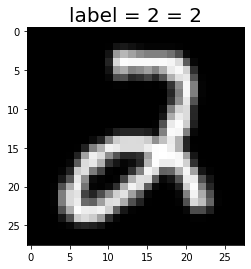

In [5]:
model.show_random_image(model.raw_train_img, model.raw_train_labels)

In [6]:
model.cnn.summary()
model.cnn.compile(loss = "categorical_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 12, 12, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
model.trained = model.cnn.fit(model.train_img,
              model.train_labels,
              batch_size = model.batch_size,
              epochs = model.epochs,
              verbose = 1,
              validation_data = (model.test_img, model.test_labels))

model.cnn.save(model.save_path)

Train on 697932 samples, validate on 116323 samples
Epoch 1/50
697932/697932 [==============================] - 9s 12us/sample - loss: 0.8841 - accuracy: 0.7391 - val_loss: 0.4599 - val_accuracy: 0.8393
Epoch 2/50
697932/697932 [==============================] - 7s 11us/sample - loss: 0.5073 - accuracy: 0.8273 - val_loss: 0.4109 - val_accuracy: 0.8524
Epoch 3/50
697932/697932 [==============================] - 7s 11us/sample - loss: 0.4635 - accuracy: 0.8390 - val_loss: 0.3912 - val_accuracy: 0.8583
Epoch 4/50
697932/697932 [==============================] - 7s 11us/sample - loss: 0.4402 - accuracy: 0.8455 - val_loss: 0.3823 - val_accuracy: 0.8603
Epoch 5/50
697932/697932 [==============================] - 7s 11us/sample - loss: 0.4263 - accuracy: 0.8483 - val_loss: 0.3750 - val_accuracy: 0.8615
Epoch 6/50
697932/697932 [==============================] - 8s 11us/sample - loss: 0.4167 - accuracy: 0.8512 - val_loss: 0.3697 - val_accuracy: 0.8645
Epoch 7/50
697932/697932 [================

In [ ]:
plt.figure(figsize=(12, 6), dpi=96)
plt.subplot(1, 2, 1)
plt.plot(model.trained.history['loss'])
plt.plot(model.trained.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(model.trained.history['accuracy'])
plt.plot(model.trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()